# Zillow Clustering Project

## Project Goal 
* Discover driver of log error from the zillow database.
* Use drivers to develop machine learning model to predict log error
* This information will be used to further our understanding of which elements contribute to or detract from log error

# Imports

In [1]:
#DS imports
import pandas as pd
import env
import numpy as np
from scipy import stats
from scipy.stats import levene, f_oneway

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#SK Learn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

#Helper file imports
import os
import wrangle as w
import explore as e
import model as m

#Turn off warnings
import warnings
warnings.filterwarnings('ignore')

#Change float format
pd.options.display.float_format = '{:.3f}'.format

# Aquire
* Data aquired from Codeup MySQL database, cached into a .csv file for local access
* It contains 52442 rows and 69 features before cleaning
* Each row represents a house in the zillow dataset
* Each columns represents a feature of the house

# Prepare
###### Prepare Actions:
* Removed columns that did not contain useful information
* Renamed columns to provide readability
* Checked that column data types were appropriate
* Removed white space from values in object columns
* Checked for null values in the data, removed nulls using a function inside prep called 'handle_missing_values'
* Imputed missing values with zeroes where appropriate
* Outliers were not removed in this iteration

# Data Dictionary
| Feature | Definition |
|:--------|:-----------|
|fips| Federal Information Processing Standard code -  see https://en.wikipedia.org/wiki/FIPS_county_code for more detail|
|latitude| Latitude of the middle of the parcel multiplied by 10e6|
|longitude| Longitude of the middle of the parcel multiplied by 10e6|
|LA| fips code for LA county|
|Orange| fips code for Orange county|
|Ventura| fips code for Ventura county|
|yearbuilt| The Year the principal residence was built|
|age| The year sold, 2017, minus the yearbuilt|
|age_bin| The age of the residence divided into several bins|
|taxamount| The total property tax assessed for that assessment year|
|taxrate| The taxamount divided by tax value multiplied by 100|
|taxvalue| The total tax assessed value of the parcel|
|lot_sqft| Area of the lot in square feet|
|acres| lot_sqft divided by 43560|
|acres_bin| The acres of residence divided into several bins|
|sqft_bin| The sqft of residence divided into several bins|
|structure_dollar_per_sqft| The tax value divided by sqft|
|structure_dollar_sqft_bin| A division of the structure dollar divided into several bins|
|land_dollar_per_sqft| land_value divided by lot_sqft|
|lot_dollar_sqft_bin| land_dollar_per_sqft divided into several bins|
|bath_count| number of bathrooms in residence|
|bed_count| number of bedrooms in residence|
|bath_bed_ratio| bath_count divided by bed_count|
|cola| Whether or not a residence is in the city of LA|

In [2]:
# aquire the data
df = w.acquire_zillow()

In [3]:
# preparing the data 
df = w.prepare_zillow(df)

### Feature Engineering

* "age":    year sold, 2017, minus the yearbuilt
* "taxrate":    taxamount divided by tax value multiplied by 100
* "acres":	lot_sqft divided by 43560
* "structure_dollar_per_sqft":   tax value divided by sqft
* "land_dollar_per_sqft": 	land_value divided by lot_sqft
* "bath_bed_ratio":	bath_count divided by bed_count
* "cola":	  whether or not a residence is in the city of LA

In [4]:
#creating features for exploration and modeling
df = e.create_features(df)

In [5]:
# split data into train, validate and test (70/15/15 split)
train, validate, test = w.train_validate_test_split(df)

## A brief look at the data

In [6]:
#Peeking at the data
train.head()

,parcel_id,propertylandusetypeid,basement_sqft,bath_count,bed_count,calc_bath_and_bed,decktypeid,calc_sqft,finished_sqft12,fips,...,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
38935,14392368,261.000,0.000,2.500,4.000,2.500,0.000,2832.000,2832.000,6059.000,...,0.990,0.173,0.200,0.600,130.530,0.400,35.482,0.300,0.625,0
31408,14368210,261.000,0.000,2.500,4.000,2.500,0.000,2255.000,2255.000,6059.000,...,1.037,0.161,0.200,0.500,75.004,0.300,19.219,0.200,0.625,0
30966,11300975,261.000,0.000,3.000,3.000,3.000,0.000,1563.000,1563.000,6037.000,...,1.985,0.164,0.200,0.400,58.163,0.200,3.176,0.100,1.000,0
5412,13926000,261.000,0.000,2.000,3.000,2.000,0.000,1447.000,1447.000,6059.000,...,1.802,0.175,0.200,0.300,32.089,0.100,4.071,0.100,0.667,0
45802,17229160,261.000,0.000,2.500,3.000,2.500,0.000,1415.000,1415.000,6111.000,...,1.235,0.101,0.100,0.300,128.823,0.400,22.876,0.300,0.833,0


____

# Explore

In [7]:
#Scale data to create clusters
train_scaled, validate_scaled, test_scaled = m.scale_data(train, validate, test, 
                                                        columns_to_scale =
                                                       ['latitude','longitude','age','bath_bed_ratio', 'calc_sqft',
                                                       'taxrate','structure_dollar_per_sqft','tax_value'])

In [8]:
#Creating Clusters for exploration
train, train_scaled, validate_scaled, test_scaled = m.create_clusters(train, train_scaled, validate_scaled, test_scaled)

## Question 1: What is the distribution of logerror? Exploration of the target variable

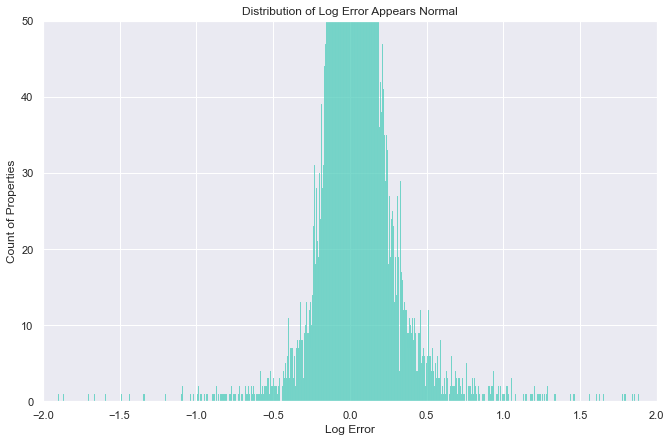

In [9]:
# get barchart of log_error
e.logerror_distribution(train)

##### The distribution of log error appears even. So most logerror is a slight difference in actual value in either the positive or negative direction.

___

## Question 2: Is a property more likely to be over evaluated or under evaluated?

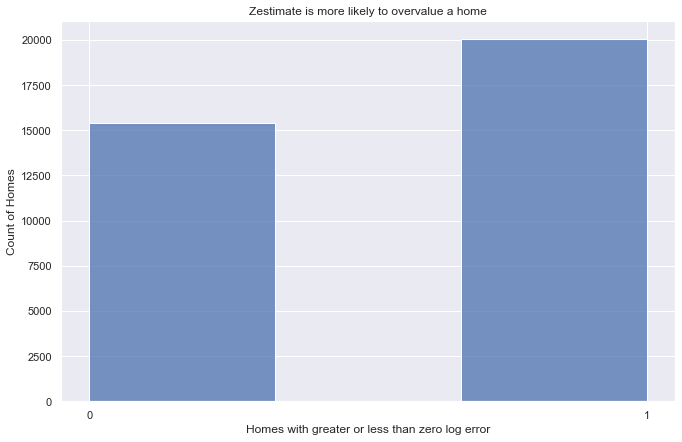

In [10]:
e.zestimate(train)

###### A property is more likely to be over evaluated then under.

___

## Question three: If we cluster location data with home age, is there a relationship with log error?

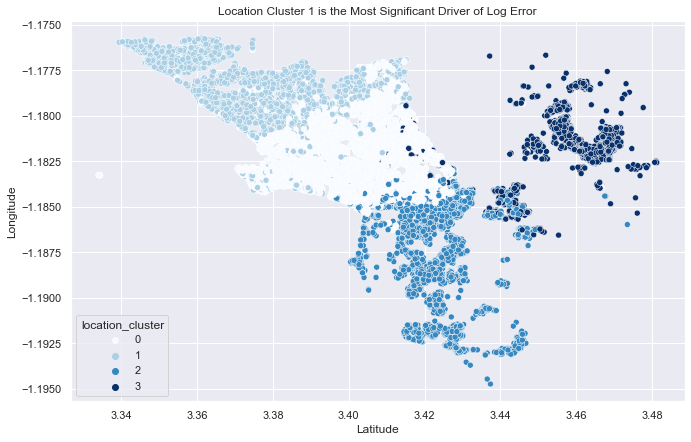

In [11]:
#Get Location Cluster Visualization
e.loc_cluster_viz(train)

#### Location Cluster 1, with latitude, longitude, and home age, shows a significant difference in log error (see statistical test below). Referring to actual geographic data,  Location Cluster 1 is predominately the area of Ventura County.

### Statistical Testing

#### Establish Hypothesis:
Hypotheses:

$H_0$: Cluster One has the equal mean log error to train

$H_a$: Cluster One does not have equal meal log error to train

I used a 95% confidence interval
The resulting alpha value is .05

In [12]:
#Run the Test
e.location_ttest(train)

Test Statistic: 4.66, P-Value: 0.0


#### The means of these two groups are different, so we can reject the null hypothesis--Cluster One mean log error is significantly different than train.

____

## Question four: If we cluster size features (Bathroom/Bedroom Ratio and Calculated Finished Square Feet), is there a relationship with log error?

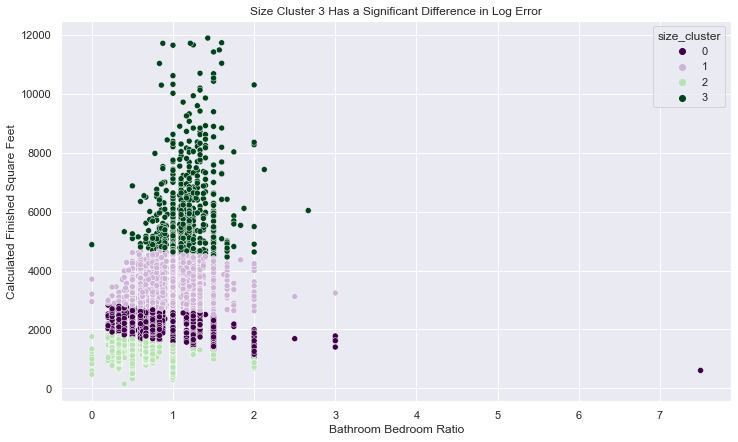

In [13]:
#Get Size Cluster Visualization
e.size_cluster_viz(train)

### Cluster 3, containing properties with very high finished square feet, have a higher mean log error

### Statistical Testing

#### Establish Hypothesis:
Hypotheses:

$H_0$: Size cluster three (3) has the equal mean log error to train

$H_a$: Size cluster three (3) does not have equal meal log error to train

I used a 95% confidence interval
The resulting alpha value is .05

In [14]:
e.size_ttest(train)

Test Statistic: 3.98, P-Value: 0.0


#### The means of these two groups are different, so we can reject the null hypothesis--size cluster three (3) mean log error is significantly different than train.

## Question Five: If we cluster value features (Tax Value, Structure Dollar Square Feet), is there a relationship with log error?

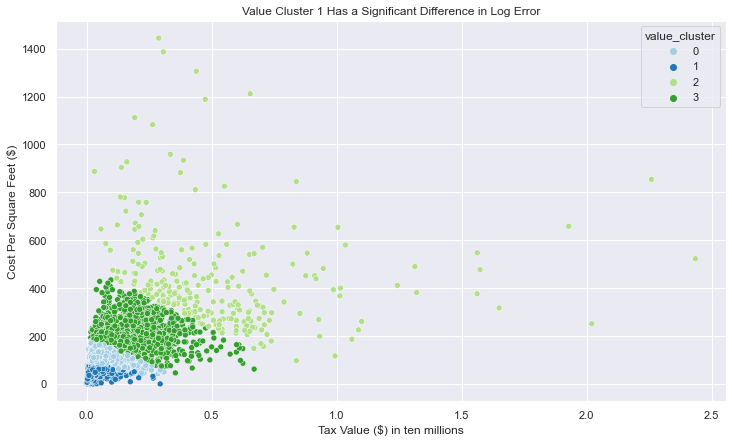

In [15]:
#Get Value Cluster Visualization
e.value_cluster_viz(train)

### Value Cluster 1, containing properties with low cost per square feet and low tax value, have a significant difference in log error compared to other clusters and the baseline

## Statistical Testing

#### Establish Hypothesis:
Hypotheses:

$H_0$: Value cluster one (1) has the equal mean log error to train

$H_a$: Value cluster one (1) does not have equal meal log error to train

I used a 95% confidence interval
The resulting alpha value is .05

In [16]:
#Run Value Cluster T-Test
e.value_ttest(train)

Test Statistic: 3.16, P-Value: 0.0


#### The means of these two groups are different, so we can reject the null hypothesis--size cluster three (3) mean log error is significantly different than train.

# Exploration Summary
* The distribution of log_error is very slight and even
* A property is more likely to be overvalued than undervalued
* Location Cluster One had a significantly different log error than other clusters
* Size Cluster Three had a significantly different log error than other clusters
* Value Cluster One had a significantly different log error than other clusters

# Features we are Moving to modeling with
* Location Cluster One
* Size Cluster Three
* Value Cluster One
* Tax Rate (Significantly Correlated with Log Error)
* COLA (City of LA) (Properties in the City of Los Angeles had a significantly different log error than properties not in the City of Los Angeles

# Features we are not Moving to modeling with
* All other clusters: we selected the most meaningful
* All other features: to avoid colinearity

# Modeling
* We will be using RMSE as the evaluation metric
* We will be evaluating models developed using four different model types and various hyperparameter configurations
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test data
* Baseline for modeling will be Log Error mean

In [17]:
#Make dummy columns from clusters
dummy_cols = ['location_cluster', 'size_cluster', 'value_cluster']

In [18]:
#Encode dummies
train_scaled, validate_scaled, test_scaled = m.encode_cat_features(train_scaled, validate_scaled, test_scaled, dummy_cols)

In [19]:
#prep data for modeling
train_X, validate_X, test_X, train_y, validate_y, test_y = m.model_prep(train_scaled, validate_scaled, test_scaled)

In [20]:
#get RMSE from baseline (mean) and median
m.get_mean_median(train_y, validate_y)

RMSE using Mean
Train/In-Sample:  0.174 
Validate/Out-of-Sample:  0.172
RMSE using Median
Train/In-Sample:  0.174 
Validate/Out-of-Sample:  0.172


## Linear Regression 

In [21]:
rmse_train, rmse_validate = m.linear_regression(train_X, train_y, validate_X, validate_y)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.17338031812488738 
Validation/Out-of-Sample:  0.17107821378186572


## LassoLars

In [22]:
rmse_train, rmse_validate = m.lassolars(train_X, train_y, validate_X, validate_y)

RMSE for Lasso + Lars
Training/In-Sample:  0.1737809920801927 
Validation/Out-of-Sample:  0.1715527503348489


In [23]:
# all features dropped except latitude, longitude, and age
rmse_train, rmse_validate = m.lassolars2(train_X, train_y, validate_X, validate_y)

RMSE for Lasso + Lars
Training/In-Sample:  0.1737809920801927 
Validation/Out-of-Sample:  0.1715527503348489


## Polynomial

In [24]:
rmse_train, rmse_validate = m.polynomial(train_X, train_y, validate_X, validate_y, test_X)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.1730304875499295 
Validation/Out-of-Sample:  0.17094629783754497


# Comparing Models
* All of the models perform very close to the baseline
* Since Polynomial performs slightly worse than the others it will be dropped
* Linear Regression will be used on the test data

## Linear Regression on Test

In [25]:
rmse_test = m.linear_regression_test(test_X, test_y)

RMSE for OLS using LinearRegression
Test/Out-of-Sample:  0.18241836142058418


## Modeling Summary
* All models performed about the same
* Linear Regression was chosen for test
* Linear Regression test performed better than baseline (a 0.008 RMSE improvement (4.8% from baseline)

# Conclusions

* Creating clusters with similar features provided some benefit to improving our models
* Zestimate is more likely to overvalue a home than undervalue
* Location matters--clustering provided a valuable feature towards the model
* Properties with larger square footage seem to be a better predictor of log error (size cluster)
* Lower value properties (value cluster) provided a better prediction of log error

## Recommendation
* Feature engineering suburban vs. urban areas is likely to provide value to a model
* Feature engineering neighborhoods within the three counties is likely to improve modeling
* Additional creation of clusters could provide more insight into log error

# Next Steps
* Better data collection from real estate agents and brokers will help avoid missing values, which plague this dataset
* Features that include amenities that are not part of a home, such as crime rate, distance from hospitals, and school districts are likely to add value to a model